# Initial Setup

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/ITRPA_PROJ"
OUTPUT_DIR = os.path.join(BASE_DIR, "outputs_colab")

req_path = os.path.join(BASE_DIR, "collab_requirements.txt")
!pip install -q -r "{req_path}"

Mounted at /content/drive


In [3]:
def setup_paths(model_name: str):
    base = "/content/drive/MyDrive/ITRPA_PROJ"
    output = os.path.join(base, "outputs_colab")
    model_dir = os.path.join(output, model_name)
    os.makedirs(model_dir, exist_ok=True)
    return base, output, model_dir


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct 11 20:50:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   41C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


# Imports

In [6]:
import pickle
import json

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    roc_curve,
    auc,
    confusion_matrix
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from transformers import BertModel, BertTokenizer, Trainer, TrainingArguments, AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, f1_score
import numpy as np

from torchview import draw_graph
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load Data

In [7]:
DATA_DIR = os.path.join(BASE_DIR, "data")
os.makedirs(DATA_DIR, exist_ok=True)

def load_datafile(data_filename="reviews.csv", base_dir=BASE_DIR):
    """
    Loads a CSV dataset, extracts Review and Label columns,
    maps numeric ratings (1–5) to sentiment categories,
    and label-encodes them for modeling.

    Mapping:
        1,2 → negative
        3   → neutral
        4,5 → positive

    Parameters
    ----------
    data_filename : str
        CSV filename (default: 'reviews.csv')
    base_dir : str
        Base directory (default: BASE_DIR)

    Returns
    -------
    X : pd.Series
        Text reviews
    y_encoded : np.ndarray
        Encoded sentiment labels (0=negative, 1=neutral, 2=positive)
    label_enc : LabelEncoder
        Fitted encoder mapping sentiments to integers
    """
    data_dir = os.path.join(base_dir, "data")
    os.makedirs(data_dir, exist_ok=True)

    data_path = os.path.join(data_dir, data_filename)
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"File not found: {data_path}")

    # Load and validate
    df = pd.read_csv(data_path)
    if not {"Review", "Label"}.issubset(df.columns):
        raise ValueError("CSV must contain 'Review' and 'Label' columns.")

    # Extract X and y
    X = df["Review"].astype(str)
    y = pd.to_numeric(df["Label"], errors="coerce")

    # Validate label range
    if not y.dropna().between(1, 5).all():
        raise ValueError("Label column must contain numeric values 1–5.")

    # Map numeric labels to sentiment
    y_sentiment = y.map({1: "negative", 2: "negative",
                         3: "neutral",
                         4: "positive", 5: "positive"})

    # Encode sentiment labels
    label_enc = LabelEncoder()
    y_encoded = label_enc.fit_transform(y_sentiment)

    # Summary
    print(f"Loaded '{data_filename}' with shape {df.shape}")
    print("Sentiment distribution:")
    print(y_sentiment.value_counts())
    print("Label mapping:", dict(zip(label_enc.classes_, label_enc.transform(label_enc.classes_))))

    return X, y_encoded, label_enc

# Example usage
DATA_FILE = "reviews.csv"
X, y, label_enc = load_datafile(DATA_FILE)
print("Shapes:", X.shape, y.shape)

Loaded 'reviews.csv' with shape (107018, 3)
Sentiment distribution:
Label
positive    97227
neutral      5071
negative     4720
Name: count, dtype: int64
Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Shapes: (107018,) (107018,)


# Train Test Split

In [8]:
def prepare_splits(X, y, train_size=0.7, random_state=42):
    """
    Splits X and y into train, validation, and test sets,
    then fits and applies a LabelEncoder consistently across all.

    Parameters
    ----------
    X : array-like or DataFrame
        Input features.
    y : array-like or Series
        Target labels.
    train_size : float, default=0.7
        Proportion of data to use for training.
    random_state : int, default=42
        Random seed for reproducibility.

    Returns
    -------
    X_train, X_val, X_test : arrays/DataFrames
        Feature splits.
    y_train_enc, y_val_enc, y_test_enc : arrays
        Encoded label splits.
    label_enc : LabelEncoder
        Fitted LabelEncoder instance.
    """

    # First split train vs temp (val+test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        train_size=train_size,
        random_state=random_state,
        stratify=y
    )

    # Split temp equally into val/test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=random_state,
        stratify=y_temp
    )

    # Label encode consistently across all sets
    label_enc = LabelEncoder()
    label_enc.fit(list(y_train) + list(y_val) + list(y_test))

    y_train_enc = label_enc.transform(y_train)
    y_val_enc   = label_enc.transform(y_val)
    y_test_enc  = label_enc.transform(y_test)

    # Print summary
    print(f" Train: {len(X_train)/len(X):.1%}")
    print(f" Val:   {len(X_val)/len(X):.1%}")
    print(f" Test:  {len(X_test)/len(X):.1%}")
    print("Classes found:", label_enc.classes_)

    return X_train, X_val, X_test, y_train_enc, y_val_enc, y_test_enc, label_enc

In [9]:
X_train, X_val, X_test, y_train_enc, y_val_enc, y_test_enc, label_enc = prepare_splits(X, y)


 Train: 70.0%
 Val:   15.0%
 Test:  15.0%
Classes found: [0 1 2]


# Base Model Or Embedding and CONFIG

In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
CONFIG = {
    # ----------------- model setup -----------------
    "model_name": "bert-base-uncased",   # swap for roberta-base etc.
    "num_classes": 3,
    "hidden_size": 320,
    "dropout": 0.5,
    "activation": "relu",
    "fine_tune_base": True,

    # ----------------- data setup ------------------
    "max_len": 128,
    "batch_size": 16,

    # ----------------- training setup --------------
    "epochs": 3,
    "learning_rate": 2e-5,
    "optimizer": "adamw",                 # 'adam', 'sgd', etc.
    "loss_fn": "crossentropy",            # 'crossentropy', 'bce', 'mse'
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}


In [12]:
def load_base_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    base_model = AutoModel.from_pretrained(model_name)
    print(f"Loaded base model: {model_name}")
    return tokenizer, base_model

# Create Dataset Class

In [13]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create Modular Models

In [14]:
class TransformerLSTMClassifier(nn.Module):
    def __init__(self, base_model, num_classes=3, input_size=768,
                 hidden_size=320, dropout=0.5, activation="relu",
                 fine_tune_base=True):
        super().__init__()

        self.base_model = base_model
        self.num_classes = num_classes
        self.input_size = input_size

        # Optionally freeze transformer layers
        for param in self.base_model.parameters():
            param.requires_grad = fine_tune_base

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )

        # Dynamic activation lookup
        activations = {
            "relu": nn.ReLU(),
            "tanh": nn.Tanh(),
            "sigmoid": nn.Sigmoid(),
            "gelu": nn.GELU(),
            "leakyrelu": nn.LeakyReLU()
        }
        act = activations.get(activation.lower(), nn.ReLU())

        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 80),
            act,
            nn.Linear(80, 20),
            act,
            nn.Linear(20, num_classes)
        )

    def forward(self, inputs):
        """
        inputs: dict from tokenizer (input_ids, attention_mask)
        returns: raw logits (not softmaxed)
        """
        transformer_out = self.base_model(**inputs)
        token_embeddings = transformer_out.last_hidden_state  # [batch, seq_len, hidden]
        lstm_out, _ = self.lstm(token_embeddings)
        last_hidden = lstm_out[:, -1, :]  # final timestep
        logits = self.classifier(last_hidden)
        return logits

# Create Optimizer and Loss function Helpers

In [15]:
def build_optimizer(model, optimizer_name, lr):
    optimizers = {
        "adamw": torch.optim.AdamW,
        "adam": torch.optim.Adam,
        "sgd": torch.optim.SGD
    }
    if optimizer_name.lower() not in optimizers:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")
    if optimizer_name.lower() == "sgd":
        return optimizers[optimizer_name.lower()](model.parameters(), lr=lr, momentum=0.9)
    return optimizers[optimizer_name.lower()](model.parameters(), lr=lr)

def build_loss(loss_name, class_weights=None):
    loss_name = loss_name.lower()

    if loss_name == "crossentropy":
        if class_weights is not None:
            return nn.CrossEntropyLoss(weight=class_weights)
        return nn.CrossEntropyLoss()

    elif loss_name == "bce":
        return nn.BCEWithLogitsLoss()

    elif loss_name == "mse":
        return nn.MSELoss()

    else:
        raise ValueError(f"Unsupported loss: {loss_name}")


In [16]:
def compute_class_weights(y_train, device):
    """
    Compute balanced class weights for CrossEntropyLoss.

    Args:
        y_train: array-like of encoded class labels (e.g., [0, 1, 2, 2, 0, ...])
        device: torch.device to move the tensor to (e.g., 'cuda' or 'cpu')

    Returns:
        class_weights: torch.Tensor of shape [num_classes]
        weights_dict:  dict mapping class_id -> weight (for logging)
    """
    y_train = np.array(y_train)
    classes = np.unique(y_train)

    weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y_train
    )

    class_weights = torch.tensor(weights, dtype=torch.float).to(device)
    weights_dict = dict(zip(classes.tolist(), weights.tolist()))

    print("Computed class weights:", weights_dict)
    return class_weights, weights_dict

# Create Data Loader Class

In [17]:
def create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test,
                       tokenizer, max_len, batch_size):
    def make_loader(X, y, shuffle, balance=False):
        dataset = TextDataset(
            texts=X.tolist() if hasattr(X, "tolist") else list(X),
            labels=y.tolist() if hasattr(y, "tolist") else list(y),
            tokenizer=tokenizer,
            max_len=max_len
        )

        if balance:
            labels = np.array(y)
            class_counts = np.bincount(labels)
            class_weights = 1.0 / np.maximum(class_counts, 1)
            sample_weights = class_weights[labels]
            sampler = WeightedRandomSampler(
                weights=torch.DoubleTensor(sample_weights),
                num_samples=len(sample_weights),
                replacement=True
            )
            return DataLoader(dataset, batch_size=batch_size, sampler=sampler)
        else:
            return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    train_loader = make_loader(X_train, y_train, shuffle=False, balance=True)   # For training
    train_eval_loader = make_loader(X_train, y_train, shuffle=False, balance=False)  # For eval
    val_loader   = make_loader(X_val, y_val, shuffle=False)
    test_loader  = make_loader(X_test, y_test, shuffle=False)

    print(f"Dataloaders ready — Train: {len(train_loader.dataset)}, "
          f"Val: {len(val_loader.dataset)}, Test: {len(test_loader.dataset)}")
    return train_loader, train_eval_loader, val_loader, test_loader


# Define Training Loop

In [18]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, device, model_name, model_dir, epochs=3):
    """
    Train and evaluate model, log accuracy/loss, and save plots.
    """
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    model.to(device)

    for epoch in range(1, epochs + 1):
        # ---------------- TRAIN ----------------
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False):
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device)
            }
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # ---------------- VALIDATE ----------------
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]", leave=False):
                inputs = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device)
                }
                labels = batch["labels"].to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * labels.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Print summary
        print(f"Epoch {epoch:02d}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%")

    # ---------------- PLOTS ----------------
    os.makedirs(model_dir, exist_ok=True)

    # Loss plot
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label="Val Loss", marker='o')
    plt.title(f"{model_name} Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    loss_path = os.path.join(model_dir, f"{model_name}_training_loss.png")
    plt.savefig(loss_path, bbox_inches="tight")
    plt.close()

    # Accuracy plot
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs + 1), train_accs, label="Train Accuracy", marker='o')
    plt.plot(range(1, epochs + 1), val_accs, label="Val Accuracy", marker='o')
    plt.title(f"{model_name} Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    acc_path = os.path.join(model_dir, f"{model_name}_training_accuracy.png")
    plt.savefig(acc_path, bbox_inches="tight")
    plt.close()

    print(f"Training complete — plots saved to:\n{loss_path}\n{acc_path}")

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs
    }

# Define Model Graph Function

In [19]:
def save_model_graph(model, dataloader, model_name, model_dir, device, show_backbone=True):
    model.eval()
    batch = next(iter(dataloader))
    inputs = {
        "input_ids": batch["input_ids"].to(device),
        "attention_mask": batch["attention_mask"].to(device)
    }

    if not show_backbone:
        class DummyBase(nn.Module):
            def __init__(self, hidden_size=768):
                super().__init__()
                self.config = type('obj', (object,), {"hidden_size": hidden_size})

            def forward(self, **kwargs):
                batch_size = kwargs["input_ids"].shape[0]
                seq_len = kwargs["input_ids"].shape[1]
                hidden_size = self.config.hidden_size
                return type('obj', (object,), {
                    "last_hidden_state": torch.randn(
                        batch_size, seq_len, hidden_size,
                        device=kwargs["input_ids"].device
                    )
                })

        model.base_model = DummyBase()

    class TorchViewWrapper(nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model
        def forward(self, inputs):
            return self.model(inputs)

    wrapped_model = TorchViewWrapper(model).to(device)
    wrapped_model.eval()

    graph = draw_graph(
        wrapped_model,
        input_data=(inputs,),
        expand_nested=True,
        depth=4,
        device=device,
        save_graph=True,
        directory=model_dir,
        filename=f"{model_name.replace('/', '_')}_graph"
    )

    print(f"✅ Saved model graph to: {model_dir}/{model_name.replace('/', '_')}_graph.png")
    return graph


# Define Evaluation Loop

In [22]:
def evaluate_model(
    model,
    test_loader,
    label_encoder,
    device,
    model_name,
    model_dir,
    num_classes=3,
    train_acc_final=None
):
    """
    Evaluate a trained model on the test set and visualize key metrics.

    Saves:
        - classification_report.json
        - roc_auc.png
        - confusion_matrix.png
        - accuracy_barplot.png (if train_acc_final provided)
    """
    os.makedirs(model_dir, exist_ok=True)
    model.to(device)
    model.eval()

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Evaluating {model_name}", leave=False):
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device)
            }
            labels = batch["labels"].to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    preds = np.array(all_preds)
    probs = np.array(all_probs)
    labels = np.array(all_labels)

    # Decode to class names
    y_true = label_encoder.inverse_transform(labels)
    y_pred = label_encoder.inverse_transform(preds)
    class_names = label_encoder.classes_

    # ---------------- Classification report ----------------
    report = classification_report(
        y_true, y_pred, target_names=class_names,
        output_dict=True, zero_division=0
    )
    report = {str(k): v for k, v in report.items()}
    report_path = os.path.join(model_dir, f"{model_name}_classification_report.json")
    with open(report_path, "w") as f:
        json.dump(report, f, indent=4)
    print(f"Classification report saved → {report_path}")

    # ---------------- ROC-AUC ----------------
    y_true_bin = label_binarize(labels, classes=np.arange(num_classes))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(num_classes):
        # Some classes might not appear in test set → handle safely
        if y_true_bin[:, i].sum() == 0:
            fpr[i], tpr[i], roc_auc[i] = [0], [0], 0.0
            continue
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro AUC (multi-class One-vs-Rest)
    macro_auc = roc_auc_score(
        y_true_bin, probs, average="macro", multi_class="ovr"
    )

    plt.figure(figsize=(7, 6))
    for i, name in enumerate(class_names):
        plt.plot(fpr[i], tpr[i], lw=2, label=f"{name} (AUC={roc_auc[i]:.3f})")
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.title(f"{model_name} ROC Curves (Macro AUC={macro_auc:.3f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)

    roc_path = os.path.join(model_dir, f"{model_name}_roc_auc.png")
    plt.savefig(roc_path, bbox_inches="tight")
    plt.close()
    print(f"ROC-AUC plot saved → {roc_path}")



# USAGE

Loaded base model: bert-base-uncased
Computed class weights: {0: 7.557707828894269, 1: 7.0339906103286385, 2: 0.36690273981995747}
Computed class weights: {0: 7.557707828894269, 1: 7.0339906103286385, 2: 0.36690273981995747}


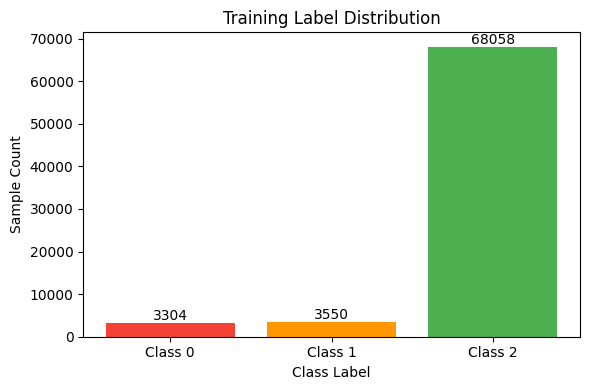

Dataloaders ready — Train: 74912, Val: 16053, Test: 16053


Epoch 01/2 | Train Loss: 0.8051, Val Loss: 0.6214 | Train Acc: 79.89%, Val Acc: 89.63%


Epoch 02/2 | Train Loss: 0.4843, Val Loss: 0.4972 | Train Acc: 89.06%, Val Acc: 85.59%
Training complete — plots saved to:
/content/drive/MyDrive/ITRPA_PROJ/outputs_colab/bert_lstm/bert_lstm_training_loss.png
/content/drive/MyDrive/ITRPA_PROJ/outputs_colab/bert_lstm/bert_lstm_training_accuracy.png
✅ Saved model graph to: /content/drive/MyDrive/ITRPA_PROJ/outputs_colab/bert_lstm/bert-base-uncased_graph.png


TypeError: evaluate_model() got an unexpected keyword argument 'train_loader'

In [23]:
MODEL_NAME = "bert_lstm"
MODEL_DIR = os.path.join(OUTPUT_DIR, MODEL_NAME)
os.makedirs(MODEL_DIR, exist_ok=True)

# ---------------- CONFIG ----------------
CONFIG['model_name']     = "bert-base-uncased"
CONFIG['activation']     = "sigmoid"
CONFIG['hidden_size']    = 320
CONFIG['dropout']        = 0.5
CONFIG['fine_tune_base'] = True
CONFIG['num_classes']    = 3

CONFIG['max_len']        = 128
CONFIG['batch_size']     = 16

CONFIG['epochs']         = 2
CONFIG['learning_rate']  = 2e-5
CONFIG['optimizer']      = "adamw"
CONFIG['loss_fn']        = "crossentropy"

CONFIG['device']         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- Load tokenizer + transformer ----------------
tokenizer, base_model = load_base_model(CONFIG["model_name"])

# ---------------- Initialize model ----------------
model = TransformerLSTMClassifier(
    base_model     = base_model,
    num_classes    = CONFIG['num_classes'],
    input_size     = base_model.config.hidden_size,
    hidden_size    = CONFIG['hidden_size'],
    dropout        = CONFIG['dropout'],
    activation     = CONFIG['activation'],
    fine_tune_base = CONFIG['fine_tune_base']
).to(CONFIG['device'])

# ---------------- Compute Class Weights ----------------
class_weights, weights_dict = compute_class_weights(y_train_enc, CONFIG["device"])
print("Computed class weights:", weights_dict)

# --- Visualize class distribution ---
y_train_np = np.array(y_train_enc)
unique, counts = np.unique(y_train_np, return_counts=True)

plt.figure(figsize=(6, 4))
plt.bar(unique, counts, color=["#f44336", "#ff9800", "#4caf50"])
plt.xticks(unique, [f"Class {c}" for c in unique])
plt.title("Training Label Distribution")
plt.xlabel("Class Label")
plt.ylabel("Sample Count")

for i, count in enumerate(counts):
    plt.text(i, count + max(counts)*0.01, str(count), ha="center", fontsize=10)

plt.tight_layout()
plt.show()

# ---------------- Optimizer and loss ----------------
optimizer = build_optimizer(model, CONFIG["optimizer"], CONFIG["learning_rate"])
criterion = build_loss(CONFIG["loss_fn"])

# ---------------- Dataloaders ----------------
train_dataloader, train_eval_dataloader, val_dataloader, test_dataloader = create_dataloaders(
    X_train, y_train_enc,
    X_val,   y_val_enc,
    X_test,  y_test_enc,
    tokenizer,
    CONFIG["max_len"],
    CONFIG["batch_size"]
)

# ---------------- Training ----------------
history = train_and_evaluate(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=CONFIG["device"],
    model_name=MODEL_NAME,  # safe filename
    model_dir=MODEL_DIR,
    epochs=CONFIG["epochs"]
)

# ---------------- Model Graph ----------------
save_model_graph(
    model,
    train_dataloader,
    CONFIG["model_name"],
    MODEL_DIR,
    CONFIG["device"],
    show_backbone=True
)

# ---------------- Evaluation ----------------
results = evaluate_model(
    model=model,
    test_loader=test_dataloader,
    label_encoder=label_enc,
    device=CONFIG["device"],
    model_name=MODEL_NAME,
    model_dir=MODEL_DIR,
    num_classes=CONFIG["num_classes"],
    train_acc_final=history["train_accs"][-1]
)


